In [5]:
import sqlite3
import pandas as pd
import filler
import trainer
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Check data quality

In [29]:
def identify_data_issues(df):
    """
    Identify duplicated timestamps, missing intervals, and 
    out-of-order rows in a time-indexed DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing a 'Time' column.
        
    Returns:
        duplicates (pd.DataFrame): Rows that contain duplicate timestamps.
        missing_intervals (pd.DatetimeIndex): Start points of intervals where data is missing.
        is_unordered (bool): True if the data is not strictly time-ordered.
    """
    # Ensure 'Time' is a datetime column
    df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
    
    # Check for any NaT (Not a Time) conversions which indicate invalid timestamps
    if df['Time'].isnull().any():
        raise ValueError("Some timestamps could not be converted to datetime.")
    
    # Check if the data is ordered by 'Time'. If not, sort it.
    if not df['Time'].is_monotonic_increasing:
        is_unordered = True
        df = df.sort_values('Time').reset_index(drop=True)
    else:
        is_unordered = False
    
    # Identify duplicates
    duplicates = df[df.duplicated(subset='Time', keep=False)]

    # Identify missing intervals
    # Calculate the difference between consecutive rows
    time_diffs = df['Time'].diff().dropna()
    # Any gap larger than 1 minute indicates missing intervals
    missing_intervals = time_diffs[time_diffs > pd.Timedelta('1min')]

    return duplicates, missing_intervals, is_unordered

# Example usage:
df = filler.read_data_from_table("ethusd")  # Assuming you have a function that reads from SQLite
duplicates, missing_intervals, is_unordered = identify_data_issues(df)
print("Duplicates:\n", duplicates)
print("Missing intervals:\n", missing_intervals)
print("Data is unordered:", is_unordered)


Duplicates:
 Empty DataFrame
Columns: [Time, Open, High, Low, Close, Volume]
Index: []
Missing intervals:
 Series([], Name: Time, dtype: timedelta64[ns])
Data is unordered: False


# Load predictions

In [30]:
# Define database connection function
def connect_to_sqlite():
    conn = sqlite3.connect("crypto_data.sqlite", check_same_thread=False)
    conn.execute("PRAGMA journal_mode=WAL;")  # Enable concurrent reads and writes
    return conn

def load_preds():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM predictions 
        WHERE timestamp > '2025-01-08 14:30:00'
        ORDER BY timestamp DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('timestamp')

preds = load_preds()
# Remove duplicate rows from the DataFrame
preds = preds.drop_duplicates()
preds

timestamp  current_close_price  predicted_next_absolute_max  \
2935  2025-01-08 14:31:00              3349.11                  3347.013672   
2934  2025-01-08 14:32:00              3357.73                  3343.228760   
2933  2025-01-08 14:33:00              3365.32                  3349.656494   
2932  2025-01-08 14:34:00              3371.75                  3358.944580   
2931  2025-01-08 14:35:00              3378.22                  3361.098877   
...                   ...                  ...                          ...   
4     2025-01-10 18:34:00              3296.53                  3287.183594   
3     2025-01-10 18:35:00              3295.19                  3296.075928   
2     2025-01-10 18:36:00              3290.58                  3286.042969   
1     2025-01-10 18:37:00              3290.15                  3295.187988   
0     2025-01-10 18:38:00              3286.35                  3288.875000   

      predicted_percentage_change  
2935                    -0.062594  
2934                    -0.431876  
2933                    -0.465439  
2932                    -0.379786  
2931                    -0.506809  
...                           ...  
4                       -0.283523  
3                        0.026885  
2                       -0.137879  
1                        0.153123  
0                        0.076833  

[2932 rows x 4 columns]

In [6]:

def load_data():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM ethusd 
        WHERE Time > '2025-01-08 13:30:00'
        ORDER BY Time DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('Time')

data = load_data()
# Remove duplicate rows from the DataFrame
data = data.drop_duplicates()

data

Time     Open     High      Low    Close    Volume
13388  2025-01-08 13:31:00  3360.00  3360.00  3357.11  3357.11  120.5655
13387  2025-01-08 13:32:00  3357.62  3359.00  3355.38  3356.34  158.7724
13386  2025-01-08 13:33:00  3356.34  3356.34  3352.49  3355.95  120.1710
13385  2025-01-08 13:34:00  3355.95  3355.95  3352.49  3353.35  125.2615
13384  2025-01-08 13:35:00  3353.98  3360.52  3353.98  3359.07   97.1543
...                    ...      ...      ...      ...      ...       ...
4      2025-01-17 20:35:00  3505.55  3511.00  3504.51  3505.00   29.3445
3      2025-01-17 20:36:00  3505.00  3505.01  3496.63  3501.94  240.7921
2      2025-01-17 20:37:00  3501.94  3505.86  3496.46  3498.13  180.0375
1      2025-01-17 20:38:00  3498.13  3507.47  3498.12  3507.47   27.0903
0      2025-01-17 20:39:00  3507.26  3507.26  3503.07  3503.07   43.4528

[13389 rows x 6 columns]

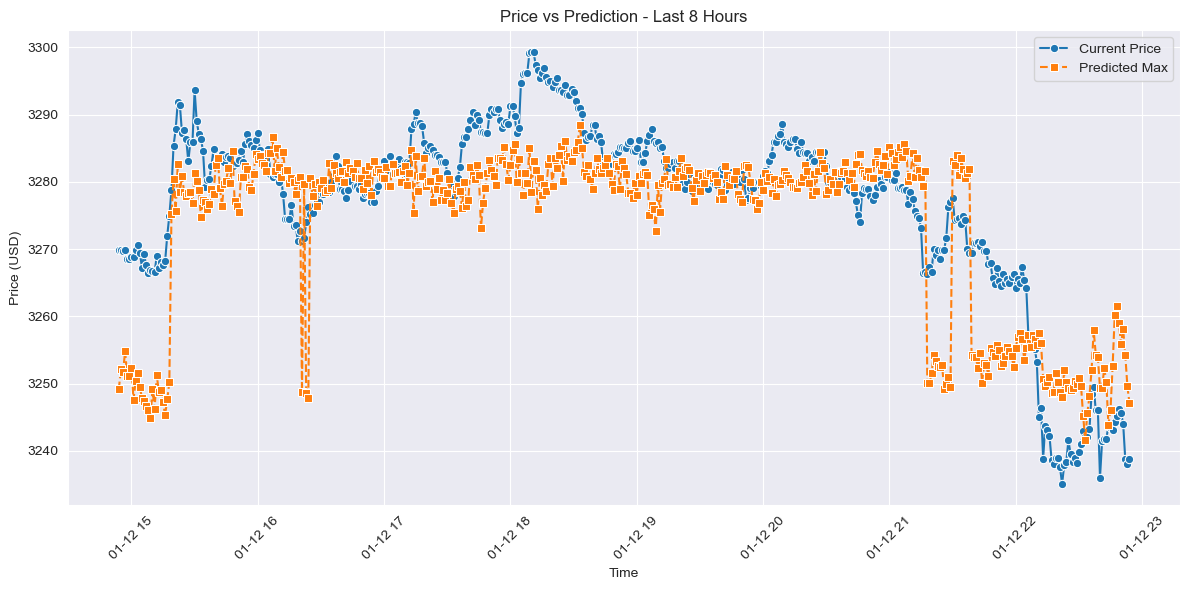

In [8]:
# Convert timestamp column
preds['timestamp'] = pd.to_datetime(preds['timestamp'])

# Filter last 3 hours
cutoff_time = preds['timestamp'].max() - timedelta(hours=8)
df_filtered = preds[preds['timestamp'] >= cutoff_time]

# Create plot
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot lines
sns.lineplot(data=df_filtered, 
            x='timestamp',
            y='current_close_price',
            label='Current Price',
            marker='o')

sns.lineplot(data=df_filtered,
            x='timestamp',
            y='predicted_next_absolute_max',
            label='Predicted Max',
            marker='s',
            linestyle='--')

# Customize plot
plt.title('Price vs Prediction - Last 8 Hours')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# Convert to datetime if not already
preds['timestamp'] = pd.to_datetime(preds['timestamp'])
data['Time'] = pd.to_datetime(data['Time'])

# Create a new column in preds for the join key: timestamp minus 60 minutes
preds['timestamp_minus_60'] = preds['timestamp'] - pd.Timedelta(minutes=60)

# Perform a left merge, matching preds.timestamp_minus_60 to data.Time
merged_df = preds.merge(
    data[['Time', 'Close']],            # Select only the columns we need from data
    how='left',
    left_on='timestamp_minus_60',
    right_on='Time'
)

# The merged_df now contains all rows from preds along with the matching 'Close' from data 
# where data.Time = preds.timestamp - 60 minutes.

# You can drop the 'Time' column (from data) and the helper column if you like:
merged_df = merged_df.drop(columns=['Time', 'timestamp_minus_60'])
merged_df['Diff_real_pred'] = 1 - merged_df['Close']/ merged_df['predicted_next_absolute_max']
merged_df


timestamp  current_close_price  predicted_next_absolute_max  \
0    2025-01-08 14:31:00              3349.11                  3347.013672   
1    2025-01-08 14:32:00              3357.73                  3343.228760   
2    2025-01-08 14:33:00              3365.32                  3349.656494   
3    2025-01-08 14:34:00              3371.75                  3358.944580   
4    2025-01-08 14:35:00              3378.22                  3361.098877   
...                  ...                  ...                          ...   
2882 2025-01-10 17:45:00              3285.23                  3287.552490   
2883 2025-01-10 17:46:00              3279.04                  3283.052979   
2884 2025-01-10 17:47:00              3284.81                  3282.734863   
2885 2025-01-10 17:48:00              3286.25                  3256.925293   
2886 2025-01-10 17:49:00              3294.45                  3284.479736   

      predicted_percentage_change    Close  Diff_real_pred  
0                       -0.062594  3357.11       -0.003017  
1                       -0.431876  3356.34       -0.003922  
2                       -0.465439  3355.95       -0.001879  
3                       -0.379786  3353.35        0.001666  
4                       -0.506809  3359.07        0.000604  
...                           ...      ...             ...  
2882                     0.070695  3260.79        0.008141  
2883                     0.122383  3260.34        0.006918  
2884                    -0.063174  3256.40        0.008022  
2885                    -0.892346  3256.30        0.000192  
2886                    -0.302638  3257.56        0.008196  

[2887 rows x 6 columns]

In [8]:
print(merged_df['Diff_real_pred'].max())
print(merged_df['predicted_percentage_change'].max())

0.034182608838269624
1.3743029834078602


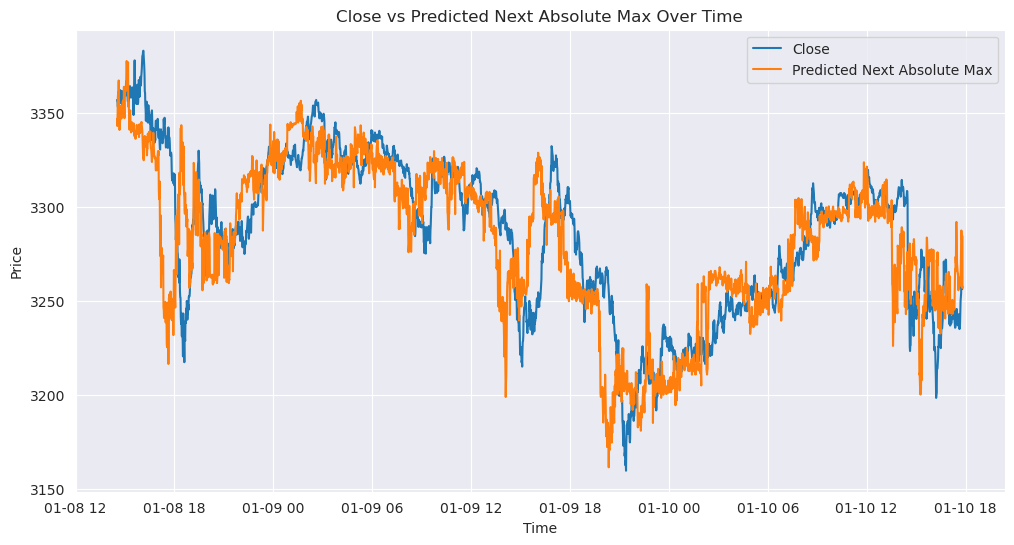

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure that timestamp is in datetime format
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='timestamp', y='Close', label='Close')
sns.lineplot(data=merged_df, x='timestamp', y='predicted_next_absolute_max', label='Predicted Next Absolute Max')

plt.title("Close vs Predicted Next Absolute Max Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


# Run trainer

In [2]:
from trainer import train_model

# Custom hyperparameters
custom_hyperparameters = {
    "n_estimators": 200,
    "max_depth": 3,
    "learning_rate": 0.1,
    "min_child_weight": 5,
    "colsample_bytree": 0.5,
    "tree_method": 'hist',
}

train_model(hyperparameters=custom_hyperparameters)

Starting model training...
Model training completed and model saved.


In [1]:
from predictor import predict_range

predict_range("2024-12-10 05:18:00", "2025-01-12 22:54:00")

Prediction: 3703.902 at 2024-12-10 06:19:00 | Close: 3715.300 | Change: -0.31%
Prediction: 3705.138 at 2024-12-10 06:20:00 | Close: 3721.050 | Change: -0.43%
Prediction: 3704.098 at 2024-12-10 06:21:00 | Close: 3721.530 | Change: -0.47%
Prediction: 3712.443 at 2024-12-10 06:22:00 | Close: 3719.820 | Change: -0.20%
Prediction: 3713.986 at 2024-12-10 06:23:00 | Close: 3719.370 | Change: -0.14%
Prediction: 3711.021 at 2024-12-10 06:24:00 | Close: 3722.700 | Change: -0.31%
Prediction: 3716.000 at 2024-12-10 06:25:00 | Close: 3723.950 | Change: -0.21%
Prediction: 3718.364 at 2024-12-10 06:26:00 | Close: 3730.310 | Change: -0.32%
Prediction: 3713.757 at 2024-12-10 06:27:00 | Close: 3726.580 | Change: -0.34%
Prediction: 3713.983 at 2024-12-10 06:28:00 | Close: 3729.130 | Change: -0.41%
Prediction: 3719.081 at 2024-12-10 06:29:00 | Close: 3731.430 | Change: -0.33%
Prediction: 3716.960 at 2024-12-10 06:30:00 | Close: 3731.800 | Change: -0.40%
Prediction: 3721.450 at 2024-12-10 06:31:00 | Close:

# Load range predictions

In [2]:
# Define database connection function
def connect_to_sqlite():
    conn = sqlite3.connect("crypto_data.sqlite", check_same_thread=False)
    conn.execute("PRAGMA journal_mode=WAL;")  # Enable concurrent reads and writes
    return conn

def load_preds():
    conn = connect_to_sqlite()
    query = """
        SELECT * 
        FROM prediction_seq
        WHERE timestamp > '2025-01-08 14:30:00'
        ORDER BY timestamp DESC 
        """
    df = pd.read_sql_query(query, conn)  # Read the data into a pandas DataFrame
    conn.close()
    return df.sort_values('timestamp')

preds = load_preds()
# Remove duplicate rows from the DataFrame
preds = preds.drop_duplicates()
preds

timestamp  current_close_price  predicted_next_absolute_max  \
6263  2025-01-08 14:31:00              3349.11                  3336.259766   
6262  2025-01-08 14:32:00              3357.73                  3343.743408   
6261  2025-01-08 14:33:00              3365.32                  3343.437012   
6260  2025-01-08 14:34:00              3371.75                  3354.920654   
6259  2025-01-08 14:35:00              3378.22                  3357.273682   
...                   ...                  ...                          ...   
4     2025-01-12 22:50:00              3245.65                  3255.882568   
3     2025-01-12 22:51:00              3244.08                  3258.130859   
2     2025-01-12 22:52:00              3238.81                  3254.327393   
1     2025-01-12 22:53:00              3238.04                  3249.678223   
0     2025-01-12 22:54:00              3238.88                  3247.081299   

      predicted_percentage_change  
6263                    -0.383691  
6262                    -0.416549  
6261                    -0.650250  
6260                    -0.499128  
6259                    -0.620040  
...                           ...  
4                        0.315270  
3                        0.433123  
2                        0.479108  
1                        0.359422  
0                        0.253214  

[6264 rows x 4 columns]

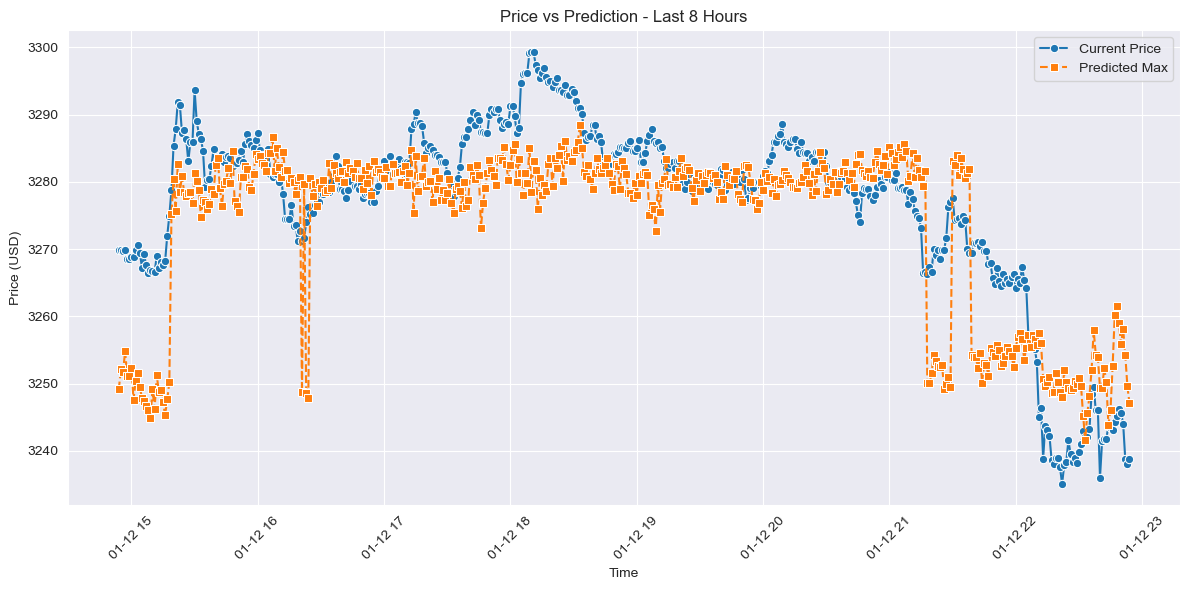

In [4]:
# Convert timestamp column
preds['timestamp'] = pd.to_datetime(preds['timestamp'])

# Filter last 3 hours
cutoff_time = preds['timestamp'].max() - timedelta(hours=8)
df_filtered = preds[preds['timestamp'] >= cutoff_time]

# Create plot
plt.figure(figsize=(12, 6))
sns.set_style("darkgrid")

# Plot lines
sns.lineplot(data=df_filtered, 
            x='timestamp',
            y='current_close_price',
            label='Current Price',
            marker='o')

sns.lineplot(data=df_filtered,
            x='timestamp',
            y='predicted_next_absolute_max',
            label='Predicted Max',
            marker='s',
            linestyle='--')

# Customize plot
plt.title('Price vs Prediction - Last 8 Hours')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [1]:
from predictor import predict_latest_price

predict_latest_price()

Prediction: 3132.472 at 2025-01-13 22:54:00 with Close 3125.890: Predicted change 0.21%
<class 'str'>


In [1]:
from trainer import train_model
train_model()

Starting model training...
Model training completed and model saved.
